<a href="https://colab.research.google.com/github/ashishpatel26/Shapelet-time-Series-Classification/blob/main/Aligning_discovered_shapelets_with_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tslearn

     |████████████████████████████████| 798kB 5.5MB/s 


In [4]:
import numpy
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [5]:
# Set a seed to ensure determinism
numpy.random.seed(42)

In [6]:
# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

In [7]:
import pandas as pd
pd.DataFrame(X_train[:,:,0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274
0,0.54407,0.65786,0.61124,0.54541,0.53216,0.59301,0.59528,0.53828,0.56343,0.59596,0.63291,0.58465,0.62319,0.60595,0.59037,0.62702,0.61349,0.62305,0.54602,0.64114,0.54939,0.61070,0.57797,0.63567,0.57422,0.60636,0.63805,0.64060,0.60581,0.65487,0.62934,0.67355,0.64083,0.67107,0.59539,0.58943,0.61587,0.66704,0.60380,0.63386,...,0.53556,0.54942,0.55353,0.59538,0.53456,0.53055,0.61195,0.58605,0.54531,0.55091,0.56394,0.60954,0.53654,0.59055,0.55313,0.58819,0.53334,0.58794,0.58297,0.59815,0.60032,0.56658,0.67194,0.62128,0.55515,0.58124,0.67464,0.57607,0.63721,0.57822,0.58823,0.57789,0.59807,0.58369,0.60288,0.55426,0.51415,0.60377,0.59633,0.58322
1,0.76643,0.62463,0.74225,0.66822,0.76612,0.73068,0.65511,0.72933,0.72365,0.70282,0.75617,0.70042,0.68231,0.70894,0.70662,0.77882,0.74962,0.72677,0.79272,0.72516,0.73404,0.69498,0.72110,0.70128,0.69025,0.78826,0.76824,0.74619,0.68759,0.75876,0.69932,0.75046,0.72633,0.69426,0.67118,0.68693,0.78832,0.71995,0.68073,0.66583,...,0.58637,0.65099,0.54138,0.62098,0.65276,0.62315,0.56573,0.62071,0.61428,0.61249,0.64243,0.64173,0.63856,0.69515,0.70527,0.68730,0.63856,0.63982,0.70826,0.68997,0.67374,0.68627,0.63037,0.73046,0.65300,0.68405,0.63268,0.65581,0.66276,0.66764,0.68619,0.68500,0.65401,0.68998,0.64181,0.67280,0.61673,0.72218,0.66786,0.72445
2,-2.04500,-2.09170,-2.07760,-2.03350,-1.99020,-2.05770,-2.01280,-2.05100,-2.05530,-2.07600,-2.00000,-2.01310,-2.04940,-2.05680,-2.04550,-2.06040,-2.07970,-2.06230,-2.02760,-2.02470,-2.00890,-2.00010,-2.05730,-2.09040,-2.04790,-1.98730,-2.07370,-2.02930,-2.01430,-2.04460,-2.05130,-2.02020,-2.03140,-1.99820,-2.01030,-2.03270,-2.03200,-2.00620,-2.01700,-2.01250,...,0.49396,0.55607,0.52739,0.52352,0.50650,0.54799,0.57457,0.58874,0.60291,0.54685,0.50110,0.61613,0.57177,0.56606,0.56036,0.54695,0.54060,0.53820,0.58579,0.54910,0.57988,0.57966,0.49634,0.55481,0.52731,0.49981,0.52698,0.53935,0.55171,0.52500,0.55547,0.52443,0.48541,0.55053,0.59755,0.60643,0.52293,0.52429,0.54742,0.57056
3,-1.70500,-1.73910,-1.72570,-1.80170,-1.74250,-1.76040,-1.69160,-1.68750,-1.76150,-1.77480,-1.78210,-1.76500,-1.73770,-1.68860,-1.74840,-1.72520,-1.77680,-1.78020,-1.74530,-1.73300,-1.76500,-1.75840,-1.75540,-1.80480,-1.74280,-1.75240,-1.77440,-1.76230,-1.68320,-1.75850,-1.70970,-1.77700,-1.74240,-1.74640,-1.75010,-1.71470,-1.75490,-1.76950,-1.78800,-1.76940,...,0.60747,0.58897,0.57047,0.63402,0.57357,0.63100,0.64216,0.62261,0.66491,0.66699,0.63428,0.63029,0.66920,0.58981,0.66506,0.61816,0.62845,0.58216,0.57262,0.58582,0.62858,0.66143,0.61961,0.66975,0.61826,0.60868,0.64777,0.60938,0.63675,0.61424,0.64928,0.64069,0.62599,0.61621,0.61688,0.65652,0.59599,0.60164,0.65616,0.58226
4,0.54137,0.57191,0.56215,0.52095,0.52749,0.60404,0.54052,0.58038,0.50058,0.59781,0.55532,0.50400,0.48722,0.52919,0.57732,0.58307,0.56387,0.51737,0.55365,0.63541,0.52845,0.56115,0.50573,0.64667,0.56248,0.56587,0.57505,0.61367,0.59095,0.54807,0.53636,0.58289,0.62480,0.54263,0.53727,0.54421,0.46517,0.51661,0.56632,0.58852,...,0.49039,0.55445,0.55328,0.57360,0.53077,0.53897,0.51796,0.52855,0.51671,0.59622,0.61819,0.57297,0.55145,0.50723,0.55504,0.54870,0.51063,0.50387,0.52631,0.56185,0.55370,0.55088,0.50170,0.55613,0.50657,0.52409,0.52285,0.59391,0.56874,0.54726,0.58600,0.62647,0.60962,0.55428,0.53947,0.53352,0.55775,0.50783,0.51377,0.52813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.60653,0.62571,0.63304,0.62139,0.60973,0.56836,0.61511,0.62784,0.61174,0.56173,0.59

In [11]:
pd.DataFrame(y_train).value_counts()

4    31
1    26
3    22
2    21
dtype: int64

In [13]:
# Filter out classes 2 and 4
mask = numpy.isin(y_train, [1, 3])
X_train = X_train[mask]
y_train = y_train[mask]

In [14]:
# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

In [15]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

In [16]:
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {20: 1}

In [18]:
# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=Adam(lr=0.01),
                            max_iter=250,
                            verbose=1,
                            scale=False,
                            random_state=42)

/usr/local/lib/python3.7/dist-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [19]:
shp_clf.fit(X_train, y_train)

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.6884 - binary_accuracy: 0.4583 - binary_crossentropy: 0.6880
Epoch 2/250
1/1 [==============================] - 0s 8ms/step - loss: 0.6874 - binary_accuracy: 1.0000 - binary_crossentropy: 0.6870
Epoch 3/250
1/1 [==============================] - 0s 9ms/step - loss: 0.6864 - binary_accuracy: 1.0000 - binary_crossentropy: 0.6860
Epoch 4/250
1/1 [==============================] - 0s 7ms/step - loss: 0.6854 - binary_accuracy: 0.8125 - binary_crossentropy: 0.6850
Epoch 5/250
1/1 [==============================] - 0s 9ms/step - loss: 0.6844 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6840
Epoch 6/250
1/1 [==============================] - 0s 10ms/step - loss: 0.6835 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6830
Epoch 7/250
1/1 [==============================] - 0s 12ms/step - loss: 0.6825 - binary_accuracy: 0.5417 - binary_crossentropy: 0.6820
Epoch 8/250
1/1 [==============================] - 0s 16ms/st

LearningShapelets(batch_size=256, max_iter=250, max_size=None,
                  n_shapelets_per_size={20: 1},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f9d54a0fd90>,
                  random_state=42, scale=False, shapelet_length=0.15,
                  total_lengths=3, verbose=1, weight_regularizer=0.001)

In [24]:
# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)

1/1 [==============================] - 0s 15ms/step


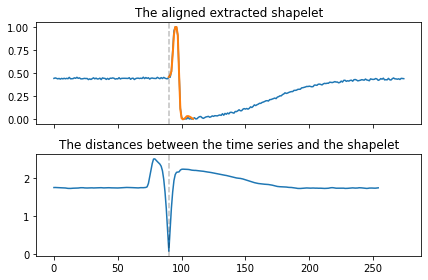

In [25]:
f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.
test_ts_id = numpy.argmin(numpy.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(numpy.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(numpy.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances)
ax[1].axvline(numpy.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()